## Cross-Wavelet Spectrum and Wavelet Coherence.

Yet another Wavelet application. 


Below you can find basically the original code available by for the [PyCWT](https://github.com/regeirk/pycwt) package (which you should install to run this example) plus with some minor modifications of mine.  

First, import the necessary tools:

In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import numpy as np
import matplotlib.pyplot as plt
import pycwt as wavelet

from pycwt.helpers import find
from matplotlib.image import NonUniformImage

Now we get some data. The ones below are the same time series used by Grinsted et al (2004).

At this point I advise you to read both Gristed et al (2004) and Torrence and Webster (1999) papers about Wavelet applications, it's basically the must-read manual for the things you will find here.

In [2]:
##--- input time series
data1 = dict(name='Arctic Oscillation',
        nick='AO', file='jao.txt')

data2 = dict(name='Baltic Sea ice extent',
        nick='BMI', file='jbaltic.txt')

In [3]:
# Loads the data to be analysed.
t1, s1 = np.loadtxt(data1['file'], unpack=True)
t2, s2 = np.loadtxt(data2['file'], unpack=True)
dt = np.diff(t1)[0]
n1 = t1.size
n2 = t2.size
n = min(n1, n2)

In [4]:
# Change the probablity density function (PDF) of the data. The time series
# of Baltic Sea ice extent is highly bi-modal and we therefore transform the
# timeseries into a series of percentiles. The transformed series probably
# reacts 'more linearly' to climate.
s2, _, _ = wavelet.helpers.boxpdf(s2)

In [5]:
# Calculates the standard deviation of each time series for later
# normalization.
std1 = s1.std()
std2 = s2.std()

### 1. Continuous Wavelet Transform (CWT)

This is the standard Torrence and Compo (1998) routine for the CWT calculations, which you probably must be familiar by now.

In [6]:
mother = wavelet.Morlet(6)          # Morlet mother wavelet with m=6
slevel = 0.95                       # Significance level
dj = 1/12                           # Twelve sub-octaves per octaves
s0 =  2 * dt                   # Starting scale, here 6 months
J = 6 / dj                    # Seven powers of two with dj sub-octaves
if True:
    alpha1, _, _ = wavelet.ar1(s1)  # Lag-1 autocorrelation for red noise
    alpha2, _, _ = wavelet.ar1(s2)  # Lag-1 autocorrelation for red noise
else:
    alpha1 = alpha2 = 0.0           # Lag-1 autocorrelation for white noise



# The following routines perform the wavelet transform and siginificance
# analysis for two data sets.

mother = 'morlet' 

W1, scales1, freqs1, coi1, _, _ = wavelet.cwt(s1/std1, dt, dj, s0, J, mother)
signif1, fft_theor1 = wavelet.significance(1.0, dt, scales1, 0, alpha1,
                                           significance_level=slevel,
                                           wavelet=mother)
W2, scales2, freqs2, coi2, _, _ = wavelet.cwt(s2/std2, dt, dj, s0, J, mother)
signif2, fft_theor2 = wavelet.significance(1.0, dt, scales2, 0, alpha2,
                                           significance_level=slevel,
                                           wavelet=mother)

power1 = (np.abs(W1)) ** 2             # Normalized wavelet power spectrum
power2 = (np.abs(W2)) ** 2             # Normalized wavelet power spectrum
period1 = 1/freqs1
period2 = 1/freqs2
sig95_1 = np.ones([1, n1]) * signif1[:, None]
sig95_1 = power1 / sig95_1             # Where ratio > 1, power is significant
sig95_2 = np.ones([1, n2]) * signif2[:, None]
sig95_2 = power2 / sig95_2             # Where ratio > 1, power is significant

### 2. Cross-Wavelet Transform (XWT)

In [7]:
# Due to the difference in the time series, the second signal 
# has to be trimmed for the XWT process.
s2 = s2[np.argwhere((t2 >= min(t1)) & (t2 <= max(t1))).flatten()]

Calculate the cross wavelet transform (XWT):

In [8]:
W12, cross_coi, freq, signif = wavelet.xwt(s1, s2, dt,
                                           dj=1/12, s0=-1, J=-1,
                                           significance_level=0.8646,
                                           wavelet='morlet',
                                           normalize=True)

cross_power = np.abs(W12)**2
cross_sig = np.ones([1, n]) * signif[:, None]
cross_sig = cross_power / cross_sig  # Power is significant where ratio > 1
cross_period = 1/freq

Calculate the wavelet coherence (WTC):

In [9]:
WCT, aWCT, corr_coi, freq, sig = wavelet.wct(s1, s2, dt,
                                             dj=1/12, s0=-1, J=-1,
                                             significance_level=0.8646,
                                             wavelet='morlet', normalize=True,
                                             cache=True)

cor_sig = np.ones([1, n]) * sig[:, None]
cor_sig = np.abs(WCT) / cor_sig  # Power is significant where ratio > 1
cor_period = 1 / freq


NOTE: WCT significance loaded from cache.



The above note means that the statistical significance was calculated before for the two time series and it's being simply loaded back. If you are going to run this for the first time, things can take some time to end so be patient (you only have to do it once, thanks to the "cache=True" option above).

Calculates the phase between both time series:

In [10]:
angle = 0.5 * np.pi - aWCT
u, v = np.cos(angle), np.sin(angle)

### 3. Plotting

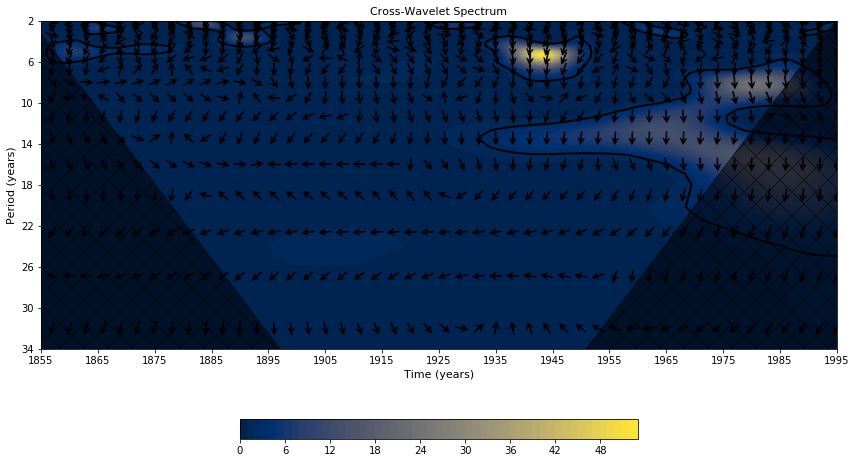

In [15]:
##--- Cross-Wavelet Spectrum and Phase 
fig, (ax1) = plt.subplots(figsize=(12,7),nrows=1, ncols=1,
                  sharex=True, sharey=True)

extent_cross = [t1.min(), t1.max(), 0, max(cross_period)]



# power spectrum contours
im1 = ax1.contourf(t1, cross_period, cross_power, 60,
            cmap='cividis')

# statistical significance contours
ax1.contour(t1, cross_period, cross_sig,
           [-99, 1], colors='k', linewidths=2,
            extent=extent_cross)

# (literal) cone of influence
ax1.fill(np.concatenate([t1, t1[-1:]+dt, t1[-1:]+dt,
                         t1[:1]-dt, t1[:1]-dt]),
         np.concatenate([cross_coi, [1e-9], cross_period[-1:],
                         cross_period[-1:], [1e-9]]),
         color='Black',alpha=0.5,hatch="x")

# phase arrows
ax1.quiver(t1[::3], cross_period[::3], u[::3, ::3], v[::3, ::3],
           units='width', angles='uv', pivot='mid', linewidth=1,
           edgecolor='k', headwidth=10, headlength=10,
           headaxislength=5,
           minshaft=2, minlength=5)


# set axis limits and range
ax1.set_xlim([1855, 1990])
ax1.set_xticks(range(1855,2000, 10))

ax1.set_ylim([2,34])
ax1.set_yticks(range(2,36, 4))


ax1.invert_yaxis() # invert y axis (scales)

plt.colorbar(im1, orientation='horizontal', shrink=0.5)
plt.xlabel('Time (years)',fontsize=11)
plt.ylabel('Period (years)',fontsize=11)
plt.title('Cross-Wavelet Spectrum',fontsize=11)


plt.tight_layout()
plt.show()

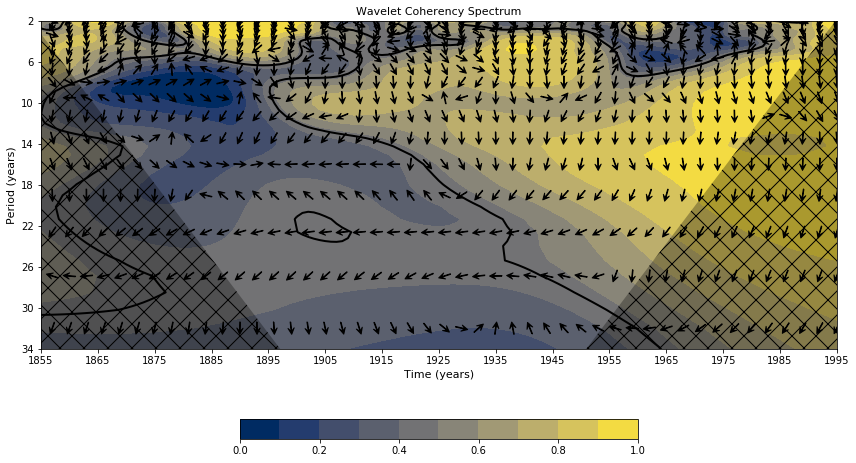

In [14]:
##--- Wavelet Coherence Spectrum and Phase 
fig, (ax2) = plt.subplots(figsize=(12,7),nrows=1, ncols=1,
                  sharex=True, sharey=True)

extent_corr =  [t1.min(), t1.max(), 0, max(cor_period)]
inter       =  np.arange(0, 1.1, 0.1)

# coherence spectrum contours
im2 =  ax2.contourf(t1, cor_period, WCT, inter,
                    cmap='cividis')

# statistical significance contours
ax2.contour(t1, cor_period, cor_sig, [-99, 1],
            colors='k', linewidths=2,
            extent=extent_corr)

# (literal) cone of influence
ax2.fill(np.concatenate([t1, t1[-1:]+dt, t1[-1:]+dt,
                         t1[:1]-dt, t1[:1]-dt]),
         np.concatenate([corr_coi, [1e-9], cor_period[-1:],
                         cor_period[-1:],
                         [1e-9]]),
         'k', alpha=0.3, hatch='x')

# phase arrows
ax2.quiver(t1[::3], cor_period[::3], u[::3, ::3], v[::3, ::3],
           units='height',
           angles='uv', pivot='mid', linewidth=1, edgecolor='k',
           headwidth=10, headlength=10, headaxislength=5, minshaft=2,
           minlength=5)

plt.colorbar(im2, orientation='horizontal', shrink=0.5)



# set axis limits and range
ax2.set_xlim([1855, 1990])
ax2.set_xticks(range(1855,2000, 10))

ax2.set_ylim([2,34])
ax2.set_yticks(range(2,36, 4))

ax2.invert_yaxis() # invert y axis


plt.xlabel('Time (years)',fontsize=11)
plt.ylabel('Period (years)',fontsize=11)
plt.title('Wavelet Coherency Spectrum',fontsize=11)


plt.tight_layout()
plt.show()

A note on the phase arrows: the interpretation should not be made according to Grinsted et al (2004), but Torrence and Webster (1999) and Torrence and Compo (1998), even though the XWT spectrum is the same as the first.


Apart from the technical and theoretical details, your XWT analysis should go nice and smoothly as the above example thanks to the guys responsible for the PyCWT package. So cheers to them!

## References

#### 1. Grinsted, A., Moore, J. C., & Jevrejeva, S. (2004). Application of the cross wavelet transform and wavelet coherence to geophysical time series. Nonlinear processes in geophysics, 11(5/6), 561-566.

#### 2. Torrence, C., & Webster, P. J. (1999). Interdecadal changes in the ENSO–monsoon system. Journal of Climate, 12(8), 2679-2690.

#### 3. Torrence, C., & Compo, G. P. (1998). A practical guide to wavelet analysis. Bulletin of the American Meteorological society, 79(1), 61-78.